# **Install Requeriments**

Connecta com a tua google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Instalar os requeriemntos do Alpaca API

In [2]:
pip install alpaca-trade-api

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.7/757.7 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 4.4 MB/s eta 0:00:00
  Created wheel for msgpack: filename=msgpack-1.0.3-cp311-cp311-linux_x86_64.whl size=15688 sha256=6fa3c4d38c63c39f930150091ec78640506bb67265e69ec458a9a230cd98867b
  Stored in directory: /root/.cache/pip/wheels/f6/35/da/ed9b26b510235e00e3a3c3bab7bad97b59214729662255ab3d
Successfully built msgpack
  Attempting uninstall: msgpack
    Found existing installation: msgpack 1.1.0
    Uninstalling msgpack-1.1.0:
      Successfully uninstalled msgpack-1.1.0
  Attempting uninstall: websockets
    Found existing installation: websockets 15.0.1
    Uninstalling

Instalas a biblioteca necessária para calculares o garu necessário de semelhança entre strings

In [3]:
pip install python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 17.8 MB/s eta 0:00:00


Instalas a biblioteca necessária para calculares o garu necessário de semelhança entre strings

In [4]:
pip install fuzzywuzzy

In [5]:
import pandas as pd
import importlib
import json
import joblib
from datetime import datetime, timedelta, timezone
import alpaca_trade_api as tradeapi
import time
import os
from fuzzywuzzy import process
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as sk_confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import warnings
import matplotlib.pyplot as plt

# **Settings**

Caminho dos arquivos do Google Drive

In [6]:
# Define o caminho base do projeto
base_path = '/content/drive/MyDrive/AI Financial Analisys/Summer Project/Vasco'

# Monta os caminhos para cada categoria utilizando os nomes originais
caminho_secret_keys = os.path.join(base_path, 'API_Keys.txt')       # Arquivo de chaves de API
arquivo_old_dataset = os.path.join(base_path, 'Data', 'IEX')          # Diretório com o dataset antigo (raw data)
caminho_para_salvar_imagens = os.path.join(base_path,'Images', 'IEX', 'NoScaler')   # Diretório para salvar imagens
caminho_para_salvar_resultados = os.path.join(base_path, 'Alpaca', 'Models') # Diretório para salvar resultados do modelo
caminho_para_salvar_modelo = os.path.join(base_path, 'Alpaca', 'Models', 'IEX', 'NoScaler')      # Diretório para salvar o modelo
caminho_para_salvar_dados = os.path.join(base_path, 'Data', 'IEX')              # Diretório para salvar dados
caminho_para_salvar_scaler = os.path.join(base_path, 'Data', 'Scalers', 'IEX')              # Diretório para salvar o scaler
caminho_para_salvar_settings = os.path.join(base_path, 'Settings')    # Diretório para salvar os settings
caminho_para_salvar_report = os.path.join(base_path, 'Report')                          # Diretório para salvar o report

**Todas as variaveis que se podem perdsonalizar no algoritmo.**

As primeiras possibilidades de cada variável são aquelas as quais inicialmnete pensas-te que faziam mais sentido:

* data_source = 'sip', 'iex' (Tipos de fornecedores de dados ou IEX ou SIP.)
* symbol = 'AAPL', (retira do ficheito execel, tens o código que extrai)
* max_period = True, (podes ter erros por excesso de pedidos do API)
* start_date = '', '2022-10-31', (1 ano funciona bem para test runs)
* end_date = '', '2023-10-31', (1 ano funciona bem para test runs)
* timeframe = '1Min', '5Min', (mais de 5Min parece perder sentido a teoria)
* fisrt_marker = 'volume', 'close', 'high', 'low', 'trade_count', 'open', 'vwap', 'average_oc', 'average_hl', (a ideia inicial é ver o volume relativo, mas pode ser interessante estudar o trade_count)
* second_marker = 'vwap', 'volume', 'close', 'high', 'low', 'trade_count', 'open', 'average_oc', 'average_hl', (a ideia inicial era ver a média entre o high e o low - 'average_hl', mas fica na duvida ver a média entre o open e o close - 'average_oc', pode também ser muito interessante investigar o vwap)
* third_marker = '', 'volume', 'close', 'high', 'low', 'trade_count', 'open', 'vwap', 'average_oc', 'average_hl', (não pensas te em usar uma terceira coluna para criar as matrizes, mas se os resultados impiricos assim o provarem usa)
* n_rows = 12, 10, 15, 30, 5, (pensa no timeframe quando fazes isso, o 12 pareceu ser o melhor em testes impiricos)
* sort = True, (tens de pensar na sequencia temporal se faz sentido manter ou não)
* relative_first_marker = True, (tens de pensar em que marker correspondente estás a usar, pensa se matemáticamente faz sentido ou não colocares o marcador com valores relativos para todo o tensor, faltam te dados impiricos, o volume pensas te inicialmnete deixar em impirico para o tensor para normalizares os tensores)
* relative_second_marker = False, (tens de pensar em que marker correspondente estás a usar, pensa se matemáticamente faz sentido ou não colocares o marcador com valores relativos para todo o tensor, faltam te dados impiricos)
* relative_third_marker = False, (tens de pensar em que marker correspondente estás a usar, pensa se matemáticamente faz sentido ou não colocares o marcador com valores relativos para todo o tensor, faltam te dados impiricos)
* decimals = '', 3, 4 (tens de ver o que os dados impiricos te dizem se com arrendondamentos facilitas ou n a vida do AI)
* scaler_type = 'none' (Não se usa scaler), 'minmax' (MinMaxScaler), 'standard' (StandardScaler), 'maxabs' (MaxAbsScaler), 'robust' (RobustScaler), 'quantile' (QuantileTransformer), 'power' (PowerTransformer), 'normalize' (Normalizer), 'binarizer' (Binarizer) (com isto podes escolher qual será o scaler a ser usado no dataset)
* cols_to_scale = None (usa o scaler em todas as colunas), [0] (usas o scaler só na 1ª coluna), [0, 1] (usas o scaler na 1ª e na 2ª coluna), [0, 1, 2] (...)
* LSTM_boolean = True, (em caso de falso não usas um LSTM e partes do precipio que a relação causal deixa de ser importante para a cosntrução do tensor, quando normalizas os dados a esperança seria de não teres de usar um LSTM)
* epochs = 5, (este numero tende a ser irrelevante porque tens um checkpoint de callback referente ao melhor resultado de validation accuracy)
* early_stopping = True, (podes ligar ou desligar de forma automática o early_stopping, ou seja, o call back aqui)
* call_back = 'val_accuracy', 'val_loss', 'accuracy', 'loss' (escolhes o paramtero que monitora o call back)
* patience = 2, 50, 100, 500, 1000 (escolhes a paciencia do call back)
* batch_size = 64, 16, 32, 128, 256, 512 (varias com o tramanho do dataset, mas pensa que tens conseguido datasets bem grandes portanto usa os maiores valores)

In [7]:
# Exemplo de dicionário de configuração:
config = {
    'data_source': 'iex',
    'symbol': 'VOO',
    'max_period': False,
    'start_date': '2016-01-1',
    'end_date': '2024-12-30',
    'timeframe': '5Min',
    'fisrt_marker': 'vwap',
    'second_marker': 'trade_count',
    'third_marker': '',
    'n_rows': 36,
    'sort': False,
    'relative_first_marker': False,
    'relative_second_marker': False,
    'relative_third_marker': False,
    'decimals': '',
    'scaler_type': None,
    'cols_to_scale': [0],
    'LSTM_boolean': True,
    'epochs': 500,
    'early_stopping': True,
    'call_back': 'val_accuracy',
    'patience': 100,
    'batch_size': 128
}

# **Algorithm**

In [8]:
def assign_config_vars(config):

    data_source = config['data_source']
    symbol = config['symbol']
    max_period = config['max_period']
    start_date = config['start_date']
    end_date = config['end_date']
    timeframe = config['timeframe']
    fisrt_marker = config['fisrt_marker']
    second_marker = config['second_marker']
    third_marker = config['third_marker']
    n_rows = config['n_rows']
    sort = config['sort']
    relative_first_marker = config['relative_first_marker']
    relative_second_marker = config['relative_second_marker']
    relative_third_marker = config['relative_third_marker']
    decimals = config['decimals']
    scaler_type = config['scaler_type']
    cols_to_scale = config['cols_to_scale']
    LSTM_boolean = config['LSTM_boolean']
    epochs = config['epochs']
    early_stopping = config['early_stopping']
    call_back = config['call_back']
    patience = config['patience']
    batch_size = config['batch_size']

    return (data_source, symbol, max_period, start_date, end_date, timeframe,
            fisrt_marker, second_marker, third_marker, n_rows, sort,
            relative_first_marker, relative_second_marker, relative_third_marker,
            decimals, scaler_type, cols_to_scale, LSTM_boolean, epochs,
            early_stopping, call_back, patience, batch_size)

In [9]:
# Chamada da função, fazendo o "unpack" dos valores retornados para as variáveis:
(data_source, symbol, max_period, start_date, end_date, timeframe,
 fisrt_marker, second_marker, third_marker, n_rows, sort,
 relative_first_marker, relative_second_marker, relative_third_marker,
 decimals, scaler_type, cols_to_scale, LSTM_boolean, epochs,
 early_stopping, call_back, patience, batch_size) = assign_config_vars(config)

Uso o Yahoo Finance API para saber quando é que a empresa que estou a usar entrou no mercado, quando a empresa IPO.

In [10]:
def get_start_date():
    #Data de inicio dos dados historicos do Alpaca
    return "2016-01-01"

Saber o dia que é hoje, o dia que o código está a correr, o modelo está a ser criado

In [11]:
def get_end_date(symbol):
    # Obter a data e hora atuais
    current_date_time = datetime.now()
    # Make start timezone aware
    current_date_time = current_date_time.replace(tzinfo=timezone.utc)
    return current_date_time

Usas a tua senha da tua conta no ALpca API para usares a API, tens de te conectar á tua conta.

In [12]:
def alpaca_autentification(caminho_secret_keys):

    # Lê as linhas do arquivo
    with open(caminho_secret_keys, 'r') as f:
        lines = f.readlines()

    # Extrai cada valor (removendo possíveis quebras de linha com .strip())
    API_KEY = lines[0].strip()
    SECRET_KEY = lines[1].strip()
    BASE_URL = lines[2].strip()

    # Inicializa a API Alpaca com as credenciais lidas do arquivo
    api = tradeapi.REST(API_KEY, SECRET_KEY, BASE_URL, api_version='v2')

    return api

Depois chamas a API para retirar os dados que necessitas. Para a API não te bloquear usas um intervalo de 1 segundo sempre que chamas a API para conseguires atingir elevada granuralidade dos dados, sem seres bloqueado pela API.

In [13]:
# Function to fetch data in chunks to avoid rate limits
def fetch_data(symbol, start, end, timeframe, api, data_source='sip'):
    all_data = []
    current_start = start

    while current_start < end:
        current_end = current_start + timedelta(days=7)
        if current_end > end:
            current_end = end

        # Fetch the historical data
        bars = api.get_bars(
            symbol,
            timeframe,
            start=current_start.strftime('%Y-%m-%d'),
            end=current_end.strftime('%Y-%m-%d'),
            feed=data_source
        ).df

        all_data.append(bars)
        current_start = current_end
        time.sleep(1)  # Adjust sleep interval based on rate limits

    return pd.concat(all_data)

função para criar o nome do ficheiro. O nome do ficheiro encriptará todas varaiveis/hyperparametros necessários para voltar a correr o ficheiro do modelo ou o csv com todos os dados. (tens um dicionário do que cada uma dos paramteros representa mais a baixo)

In [14]:
def create_file_name(data_source, symbol, max_period, start_date, end_date,
                     timeframe, fisrt_marker, second_marker, third_marker,
                     n_rows, sort, relative_first_marker, relative_second_marker,
                     relative_third_marker, decimals, scaler_type, cols_to_scale,
                     LSTM_boolean, epochs, early_stopping, call_back, patience,
                     batch_size, test_loss, test_accuracy, model_file):

    if scaler_type == None:
      scaler_type = 'none'
    # Nome aproximado do arquivo
    if model_file == True:
        nome_aproximado = 'ds=' + data_source + '+' + 's=' + symbol + '+' + 'mp=' + str(max_period) + '+' + 'sd=' + \
        start_date + '+' + 'ed=' + end_date + '+' + 'tf=' + timeframe + '+' + \
        'fm=' + fisrt_marker + '+' + 'sm=' + second_marker + '+' + \
        'tm=' + third_marker + '+' + 'r=' + str(n_rows) + '+' + \
        'sort=' + str(sort) + '+' + 'rfm=' + str(relative_first_marker) + '+' + \
        'rsm=' + str(relative_second_marker) + '+' + \
        'rtm=' + str(relative_third_marker) + '+' + \
        'd=' + decimals + '+' + 'st=' + scaler_type + '+' + 'cts=' + str(cols_to_scale) + '+' + \
        'Lb=' + str(LSTM_boolean) + '+' + 'e=' + str(epochs) + '+' + \
        'es=' + str(early_stopping) + '+' + 'cb=' + call_back + '+' + \
        'p=' + str(patience) + '+' + 'bs=' + str(batch_size) + '+' + \
        'tl=' + str(test_loss) + '+' + 'ta=' + str(test_accuracy)
    else:
        nome_aproximado = 'ds=' + data_source + '+' + 's=' + symbol + '+' + 'mp=' + str(max_period) + '+' + 'sd=' + \
        start_date + '+' + 'ed=' + end_date + '+' + 'tf=' + timeframe

    return nome_aproximado

In [15]:
# Cria o nome do arquivo utilizando a função create_file_name (supondo que ela já esteja definida)
file_name_False = create_file_name(data_source, symbol, max_period, start_date, end_date,
                     timeframe, fisrt_marker, second_marker, third_marker,
                     n_rows, sort, relative_first_marker, relative_second_marker,
                     relative_third_marker, decimals, scaler_type, cols_to_scale,
                     LSTM_boolean, epochs, early_stopping, call_back, patience,
                     batch_size, 0, 0, False)

função para procurar se o modelo e os dados são originais, caso não sejamm originais é porque foi encontrado dados e pelo menos um modelo identicos ao que está a ser pedido ao algoritmo já guradado na base de dados e caso isso aconteça, os dados não seram novamente retirados da API mas sim seram usados aqueles que já se encontram na base de dados (arquivos da tua google drive). Isto é feito por compração de nomes de ficheiros, já que no nome dos ficheiros encotra-se encriptado tudo o que é necessário para voltar a correr o algoritmo em termos de hyperparamtros e variaveis.

In [16]:
def old_dataset_function(arquivo_old_dataset, nome_aproximado):

    # Lista todos os arquivos no diretório
    arquivos = os.listdir(arquivo_old_dataset)

    # Encontra o arquivo mais próximo
    if process.extractOne(nome_aproximado, arquivos):
        arquivo_mais_proximo, pontuacao = process.extractOne(nome_aproximado, arquivos)
    else:
        arquivo_mais_proximo = None
        pontuacao = None

    if arquivo_mais_proximo and pontuacao==100:
        caminho_do_modelo = os.path.join(arquivo_old_dataset, arquivo_mais_proximo)
        print("Nome do arquivo mais próximo:")
        print(arquivo_mais_proximo)
        print()
        print("Caminho completo do modelo:")
        print(caminho_do_modelo)
        print()
        print("Pontuação de similaridade:")
        print(pontuacao)
        old_dataset = True
    else:
        print("Nenhum arquivo próximo encontrado.")
        caminho_do_modelo = ''
        old_dataset = False

    return old_dataset, caminho_do_modelo

Usando a alpaca API para sacar os dados agora que já deste login á tua conta da alpaca com a tua senha pessoal anteriormente.

In [17]:
def get_all_data(caminho_secret_keys, symbol = 'AAPL', max_period = True, start_date = '', end_date= '', timeframe = '1Min', data_source = 'sip'):
    api = alpaca_autentification(caminho_secret_keys)

    if max_period and start_date == '' and end_date == '':
        start_date = get_start_date(symbol)
        end_date = get_end_date(symbol)
    elif start_date != '' and end_date != '':
        start_date = datetime.strptime(start_date, '%Y-%m-%d')
        end_date = datetime.strptime(end_date, '%Y-%m-%d')
    else:
        start_date = datetime(2022, 12, 31)
        end_date = datetime(2023, 12, 31)

    # Fetch the historical data
    apple_data = fetch_data(symbol, start_date, end_date, timeframe, api, data_source)
    return apple_data

Esta função irá preparar dos dados para o modelo. Do Alpca seram retirados multiplos parametros do mercado interessa-te selecionar apenas os que queres alimentar ao modelo para isso esat função é usada para os selecionar. podes escolher entre 'close', 'high', 'low', 'trade_count', 'open', 'volume', 'vwap', que são os parametros de mercado dados por default pelo Alpaca. Mas para além disso crias te outras 2 métricas com base nas métricas já dadas caso as queiras testar eslas são: 'average_oc' e 'average_hl', que correspondem, respetivamente, ao ponto médio entre o open e o close e o ponto médio entre o high e o low.



*   close é o preço de fecho da ação naquele intervalo temporal
*   high é o preço mais alto da ação naquele intervalo temporal
*   low é o preço mais baixo da ação naquele intervalo temporal
*   trade_count é o número de matches entre compradosres e vendedores naquele intervalo temporal
*   open é o preço de abertura da ação naquele intervalo temporal
*   vwap é o preço da ação por volume naquele intervalo temporal ( uma forma diferente de olhar para o valor intrinseco de uma ação)



In [18]:
# Function to prepare the data
def prepare_data(data, fisrt_marker, second_marker, third_marker):
    # Selecionar colunas relevantes e fazer uma cópia para evitar advertências
    data_selected = data[['close', 'high', 'low', 'trade_count', 'open', 'volume', 'vwap']].copy()

    # Calcular a média entre 'Open' e 'Close' usando .loc para evitar o SettingWithCopyWarning
    data_selected.loc[:, 'average_oc'] = data_selected[['open', 'close']].mean(axis=1)

    # Calcular a média entre 'High' e 'Low' usando .loc para evitar o SettingWithCopyWarning
    data_selected.loc[:, 'average_hl'] = data_selected[['high', 'low']].mean(axis=1)

    # Selecionar as colunas finais
    if third_marker != '':
        data_final = data_selected[[fisrt_marker, second_marker, third_marker]]
    else:
        data_final = data_selected[[fisrt_marker, second_marker]]

    return data_final

Agora temos de continuara a preparação dos dados para serem alimentado ao modelo para isso crio matrizes para segmentar os dados, cada matriz vai ter uma label: 0 ou 1. Assim o dataset vai ser constituido por ,atrizes de tamanho a defenir pelo o usuário do algoritmo e pelas suas respetivas labels de 0 ou 1. As matrizes no máximo poderão ter até 3 colunas, cada coluna representa uma metrica difrente do mercado. As linhas estam inicialmente organizadas de forma sequencial e representação a cada uma a granuralidade mínima do dataset, assim se a granuralidade é de 1 minuto e uma matriz tem 5 linhas, cada matriz representa 5 minutos continuos de métricas do mercado no tempo. As métricas de cada matriz por coluna podem ser formatadas como relativas, o que significa que as métricas da matriz seram apresentadas de forma relativa á matriz em questão, o que pode ser interessante para modelos sem ser um LSTM, pois permite que os dados históricos sejam baralhados temporalmente e manetenham coerência. Como é o caso por exemplo do preço e do volume, com a inflação é normal que o preço aumente mas não queremos que isso cause uma precepção errada de magnitude superior ao nosso modelo assim o 'relative' faz com que as métricas das matrizes apareçam como valores ponderados aos restantes valores da matriz, assim cada valor da métrica relativa é dividida pelo somatório dos valores dessa métrica presentes na matriz.

In [19]:
# Função para criar as matrizes e os labels
def create_matrices(data_final, n = 12, fisrt_marker = 'volume', second_marker = 'vwap', third_marker = '', relative_fisrt_marker = True, relative_second_marker = False, relative_third_marker = False):
    num_rows = data_final.shape[0]
    num_matrices = num_rows // n  # Número de matrizes completas que podemos formar

    matrices = []
    matrices_y = []

    for i in range(num_matrices):
        start_idx = i * n
        end_idx = start_idx + n
        matrix = data_final.iloc[start_idx:end_idx].copy()
        matrices.append(matrix.values)
        # Criar labels
        if i > 0:  # Ignorar a primeira matriz para alinhamento correto
            first_value = matrices[i][0, 1]
            last_value = matrices[i][n-1, 1]
            delta = last_value - first_value
            delta_bi = 1 if delta >= 0 else 0
            matrices_y.append(delta_bi)

    return matrices, matrices_y

Caso se entenda que a ordem temporal, devido á elevada granuraridade dos dados de uma matriz, é irrelevante, esta função permite ordenar por ordem decrescente da métrica da segunda coluna os valores de uma matriz e assim por exemplo caso na segunda coluna se tenha o valor de volume estaria se a observar em cada matriz o preço por ordem crescente do volume. Esta função pode ser ativada ou desativada e pode ser interessante para uma elevada granuralidade em que as matrizes apenas representam 5 minutos e não se está a usar uma LSTM.

In [20]:
def sort_matrices(matrices):
    # Ordenar as linhas de cada matriz por ordem decrescente da coluna Average (segunda coluna)
    matrices_x = []
    for matrix in matrices:
        sorted_indices = np.argsort(matrix[:, 1])[::-1]
        sorted_matrix = matrix[sorted_indices]
        matrices_x.append(sorted_matrix)
    return matrices_x

Funçaõ para passar as matrizes para tensores para poderem ser tartadas pelo TensorFlow

In [21]:
def tensor_creator(matrices_x, matrices_y):
    # Converter listas para arrays numpy
    matrices_x = np.array(matrices_x)
    matrices_y = np.array(matrices_y)
    return matrices_x, matrices_y

Função que integra todas as outras funções que falamos para obter o dataset e manipulá-lo conforme o utilizador do algoritmo deseja

In [22]:
def get_dataset(company_data, n_rows, sort = True, fisrt_marker = 'volume', second_marker = 'vwap' ,
                third_marker = '', relative_fisrt_marker = True, relative_second_marker = False,
                relative_third_marker = False, decimals = ''):
    matrices_x = []
    matrices_y = []

    matrices_x, matrices_y = create_matrices(company_data, n_rows, fisrt_marker, second_marker, third_marker, relative_fisrt_marker, relative_second_marker, relative_third_marker)

    if sort:
        matrices_x = sort_matrices(matrices_x)

    # Remover a última matriz de matrices_x para alinhamento com matrices_y
    if matrices_x:
        matrices_x.pop()

    matrices_x, matrices_y = tensor_creator(matrices_x, matrices_y)

    if decimals != '':
        matrices_x = np.round(matrices_x, decimals = decimals)
    return matrices_x, matrices_y

Esta função divide o dataset em treino, validação e teste. Esta divisão tem de ser feita de forma diferente caso se esteja a usar um LSTM ou não. Se for usado um LSTM para manter a ordem temporal dos dados o datset é dividido em fatias sequêncis primeiros 60% dos dados históricos para treino, proximos 20% para validação e ultimos 20% para teste. Se não for usado uma LSTM os dados históricos são formatados em matrizes, as matrizes são baralhadas e entregues baralhadas tempralmente ao modelo.

In [23]:
def split_dataset(matrices_x, matrices_y, LSTM = True):

    if LSTM:
        # Total de amostras
        n_samples = matrices_x.shape[0]

        # Índices para divisão
        train_size = int(0.6 * n_samples)  # 60% para treino
        val_size = int(0.2 * n_samples)    # 20% para validação
        test_size = n_samples - train_size - val_size  # 20% para teste

        # Dividir os dados sequencialmente
        X_train = matrices_x[:train_size]
        y_train = matrices_y[:train_size]

        X_val = matrices_x[train_size:train_size + val_size]
        y_val = matrices_y[train_size:train_size + val_size]

        X_test = matrices_x[train_size + val_size:]
        y_test = matrices_y[train_size + val_size:]
    else:
        # Dividir os dados em conjuntos de treinamento + validação e teste
        X_train_val, X_test, y_train_val, y_test = train_test_split(matrices_x, matrices_y, test_size=0.2, random_state=42)

        # Dividir o conjunto de treinamento + validação em treinamento e validação
        X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

    return X_train, X_val, X_test, y_train, y_val, y_test


Você pode definir uma função auxiliar que, usando importação dinâmica, retorna o scaler necessário em apenas algumas linhas.

In [24]:
# Função nomeada para transformação identidade (evita problemas com lambda e serialização)
def identity_func(x):
    return x

In [25]:
def get_scaler(scaler_type):

    if scaler_type in ['minmax', 'standard', 'maxabs', 'robust', 'quantile', 'power', 'normalize', 'binarizer']:
        scaler_map = {
            'minmax': 'MinMaxScaler',
            'standard': 'StandardScaler',
            'maxabs': 'MaxAbsScaler',
            'robust': 'RobustScaler',
            'quantile': 'QuantileTransformer',
            'power': 'PowerTransformer',
            'normalize': 'Normalizer',
            'binarizer': 'Binarizer'
        }
        module = importlib.import_module("sklearn.preprocessing")
        return getattr(module, scaler_map[scaler_type])()
    elif scaler_type == 'log':
        from sklearn.preprocessing import FunctionTransformer
        return FunctionTransformer(np.log1p, validate=True)
    elif scaler_type == 'identity':
        from sklearn.preprocessing import FunctionTransformer
        transformer = FunctionTransformer(identity_func, validate=True)
    else:
        raise ValueError("Tipo de scaler não suportado. Escolha entre: minmax, standard, maxabs, robust, quantile, power, normalize, binarizer, log, identity")

Aplica o escalonamento (ou transformação) aos dados 3D para LSTM, permitindo escolher quais colunas (na terceira dimensão) devem ser escalonadas. Realiza os imports apenas do scaler necessário conforme o scaler_type informado.

In [26]:
def scale_data(X_train, X_val, X_test, scaler_type=None, cols_to_scale=None):

    # Se o usuário não deseja aplicar escalonamento, retorna cópias dos dados originais.
    if scaler_type is None or scaler_type.lower() == 'none':
        return np.copy(X_train), np.copy(X_val), np.copy(X_test), None

    # Obtém o scaler dinamicamente com base no scaler_type informado.
    scaler = get_scaler(scaler_type)

    n_samples_train, timesteps, n_features = X_train.shape

    # Se não foi especificado, escala todas as colunas (todas as features).
    if cols_to_scale is None:
        cols_to_scale = list(range(n_features))

    # Cria cópias dos dados para não alterar os arrays originais
    X_train_scaled = np.copy(X_train)
    X_val_scaled = np.copy(X_val)
    X_test_scaled = np.copy(X_test)

    # Processamento dos dados de treinamento:
    # Extrai as colunas a serem escalonadas, achata para 2D,
    # aplica o fit_transform e reorganiza para 3D.
    X_train_part = X_train[:, :, cols_to_scale].reshape(-1, len(cols_to_scale))
    X_train_scaled_part = scaler.fit_transform(X_train_part)
    X_train_scaled[:, :, cols_to_scale] = X_train_scaled_part.reshape(n_samples_train, timesteps, len(cols_to_scale))

    # Processamento dos dados de validação:
    n_samples_val = X_val.shape[0]
    X_val_part = X_val[:, :, cols_to_scale].reshape(-1, len(cols_to_scale))
    X_val_scaled_part = scaler.transform(X_val_part)
    X_val_scaled[:, :, cols_to_scale] = X_val_scaled_part.reshape(n_samples_val, timesteps, len(cols_to_scale))

    # Processamento dos dados de teste:
    n_samples_test = X_test.shape[0]
    X_test_part = X_test[:, :, cols_to_scale].reshape(-1, len(cols_to_scale))
    X_test_scaled_part = scaler.transform(X_test_part)
    X_test_scaled[:, :, cols_to_scale] = X_test_scaled_part.reshape(n_samples_test, timesteps, len(cols_to_scale))

    return X_train_scaled, X_val_scaled, X_test_scaled, scaler

Função para criar o modelo de AI. Esta função permite escolher entre duas arquiteturas diferentes. É possível escolher entre usar uma LSTM, caso se queira dar prioridade á lógica temporal do mercado, ou usar uma arquitetura diferente caso não se queira dar essa relevância à ordem temporal.

Pode ser interessante não usar uma LSTM. O padrão de procedimento na industria é usar um LSTM devido ao motivo lógico que esxite uma padrão temporal de acontecimentos obvios no mercado. No entanto, para explorar outras prespetivas de olhar para o mercado, desenvolves te várias ferramentas que em teoria permitiriam olhar para o mercado sem ser relevante a ordem temporal. A ideia é que pela teoria do mercado eficiente combiando com a tua ideia de um torque financeiro, que deve abrir um curto intervalo de tempo no mercado para ganhar lucro comprativamento com os outros players do mercado. Assim se aumentares por muito a granuralidade e assim estarás a fazer previsões para a matriz seguinte, ou seja, se as matrizes apenas representam 5 minutos no mercado, logo somando essa a ideia de uma granuralidade elevada com o facto de tornar os parametros na matriz relativos, e ordenar as linhas da matriz por ordem crecente dos valores e não tempora, todas estas ferramentas juntas em teoria permitiriam analisar o mercado sem ter em conta a ordem temporal.


In [27]:
# Função para construir a rede neural
def build_model(input_shape, LSTM_boolean=True):
    warnings.filterwarnings('ignore', category=UserWarning, module='keras')
    model = Sequential()

    if LSTM_boolean:
        model.add(LSTM(64, input_shape=input_shape, return_sequences=True))
        model.add(Dropout(0.2))
        model.add(LSTM(64, return_sequences=False))
        model.add(Dropout(0.2))
    else:
        model.add(Flatten(input_shape=input_shape))
        model.add(Dense(64, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        model.add(Dense(64, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))

    # Compilando o modelo com uma taxa de aprendizado ajustada
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    model.summary()

    return model

Função para treinar o modelo, usamos earlystopping para saber qunado para de forma mais correta as épocas. Esta função também grava o histórico de treinamento assim como também testa o modelo contra o dataset de teste e grava os resultados.

In [28]:
def model_training(model, X_train, X_val, X_test, y_train, y_val, y_test, epochs=5, early_stopping = True, call_back = 'val_accuracy', patience = 2, batch_size=32):

    if early_stopping:
        early_stopping = EarlyStopping(monitor=call_back, patience=patience, restore_best_weights=True)
        history = model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, validation_data=(X_val, y_val), callbacks=[early_stopping])
    else:
        history = model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, validation_data=(X_val, y_val))

    return model, history

In [29]:
def run_model_on_test(model, X_test, y_test):
    # Avaliar o modelo nos dados de teste
    test_loss, test_accuracy = model.evaluate(X_test, y_test)

    return test_loss, test_accuracy

In [30]:
def create_confusion_matrix(model, X_test, y_test):

    y_pred = model.predict(X_test)

    # Função auxiliar para converter saídas para rótulos
    def convert_to_labels(y):
        if y.ndim > 1 and y.shape[1] > 1:
            return np.argmax(y, axis=1)
        elif np.issubdtype(y.dtype, np.floating):
            return (y > 0.5).astype("int32").flatten()
        else:
            return y.flatten() if y.ndim > 1 else y

    y_pred_labels = convert_to_labels(y_pred)
    y_test_labels = convert_to_labels(y_test)

    cm = sk_confusion_matrix(y_test_labels, y_pred_labels)
    cm_percentage = cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100

    disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage)
    disp.plot(cmap=plt.cm.Blues, values_format='.2f')
    plt.title("Confusion Matrix (%)")

    fig = disp.figure_
    return fig

função que permite dar plot dos resultados da historia de treinamento e dar plot aos resultado do modelo no dataset de teste.

In [31]:
def plot_accuracy(history):

    fig, ax = plt.subplots()
    ax.plot(history.history['accuracy'], label='Training Accuracy')
    ax.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax.set_title('Model Accuracy')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()
    return fig

In [32]:
def plot_loss(history):

    fig, ax = plt.subplots()
    ax.plot(history.history['loss'], label='Training Loss')
    ax.plot(history.history['val_loss'], label='Validation Loss')
    ax.set_title('Model Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    return fig

In [33]:
def verify_directory(caminho):

    # Verifique se o diretório existe, caso contrário, crie-o
    if not os.path.exists(caminho):
        print(f"Diretório {caminho} não existe.")
    else:
        print(f"O diretório {caminho} já existe.")

# **Results**

Função que agrega todas as anteriores para preceber se com base nas variaveis introduzidas no algoritmo, o algoritmo já foi corrido alguma vez com estes settings ou não. Caso tenha sido ele vai buscar á google drive os dados guardados anteriormente com estes settings o que otimiza o tempo que demora a correr o algoritmo, pois caso contrário é necessário usar a API Alpaca para obter todos os dados o que pode demorar bastante tempo.

In [34]:
old_dataset, caminho_do_modelo = old_dataset_function(arquivo_old_dataset, file_name_False)
if old_dataset:
    company_data = pd.read_csv(caminho_do_modelo, index_col=0)
else:
    company_data = get_all_data(caminho_secret_keys, symbol, max_period, start_date, end_date, timeframe, data_source)

company_data

Nenhum arquivo próximo encontrado.


,close,high,low,trade_count,open,volume,vwap
timestamp,,,,,,,
2020-07-27 13:30:00+00:00,295.200,295.200,295.200,1,295.200,100,295.200000
2020-07-27 14:10:00+00:00,296.540,296.540,296.540,1,296.540,100,296.540000
2020-07-27 14:25:00+00:00,296.320,296.340,296.250,6,296.340,437,296.303750
2020-07-27 14:30:00+00:00,296.310,296.320,296.300,3,296.320,300,296.310000
2020-07-27 14:35:00+00:00,296.600,296.610,296.600,4,296.610,301,296.606667
...,...,...,...,...,...,...,...
2024-12-30 20:40:00+00:00,542.340,542.345,542.000,6,542.005,570,542.184464
2024-12-30 20:45:00+00:00,542.590,542.610,542.320,29,542.320,1180,542.421123
2024-12-30 20:50:00+00:00,542.775,543.040,542.555,27,542.700,1043,542.746761


Esta função é chamada para fazer o tratamento dos dados brutos conforme as settings que o usuário decidiu antes dos dados serem alimentados ao modelo.

In [35]:
company_data_prepared = prepare_data(company_data, fisrt_marker, second_marker, third_marker)

company_data_prepared

,vwap,trade_count
timestamp,,
2020-07-27 13:30:00+00:00,295.200000,1
2020-07-27 14:10:00+00:00,296.540000,1
2020-07-27 14:25:00+00:00,296.303750,6
2020-07-27 14:30:00+00:00,296.310000,3
2020-07-27 14:35:00+00:00,296.606667,4
...,...,...
2024-12-30 20:40:00+00:00,542.184464,6
2024-12-30 20:45:00+00:00,542.421123,29
2024-12-30 20:50:00+00:00,542.746761,27


esta função separa os dadaos em matrizes com as dimensões esplicitas nas settings do algoritmo.

In [36]:
matrices_x, matrices_y = get_dataset(company_data_prepared, n_rows, sort, fisrt_marker, second_marker , third_marker, relative_first_marker, relative_second_marker, relative_third_marker, decimals)

print(matrices_x)
print(matrices_x.shape)
print(matrices_y)
print(matrices_y.shape)
print()

[[[295.2        1.      ]
  [296.54       1.      ]
  [296.30375    6.      ]
  ...
  [296.36       1.      ]
  [296.49       1.      ]
  [296.226667   4.      ]]

 [[296.393333   5.      ]
  [296.62       1.      ]
  [296.615      2.      ]
  ...
  [297.2        6.      ]
  [297.0925     3.      ]
  [297.210625   9.      ]]

 [[297.060224   6.      ]
  [297.02       1.      ]
  [296.937      6.      ]
  ...
  [297.653333  12.      ]
  [297.63       1.      ]
  [297.6        2.      ]]

 ...

 [[545.11       3.      ]
  [544.540718  11.      ]
  [544.624514   8.      ]
  ...
  [548.813333  16.      ]
  [548.475     13.      ]
  [549.254286  39.      ]]

 [[549.1575    21.      ]
  [548.772939   6.      ]
  [547.862143  35.      ]
  ...
  [543.752807   9.      ]
  [543.515      3.      ]
  [544.372473   3.      ]]

 [[545.11       3.      ]
  [544.540718  11.      ]
  [544.624514   8.      ]
  ...
  [539.708284  28.      ]
  [538.885     21.      ]
  [538.647222  36.      ]]]
(2047, 36,

Esta função divide o dataset em treino, teste e validação

In [37]:
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(matrices_x, matrices_y, LSTM_boolean)

# Exibir as formas dos arrays resultantes
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1228, 36, 2)
Shape of y_train: (1228,)
Shape of X_val: (409, 36, 2)
Shape of y_val: (409,)
Shape of X_test: (410, 36, 2)
Shape of y_test: (410,)


In [38]:
X_train, X_val, X_test, scaler = scale_data(X_train, X_val, X_test, scaler_type, cols_to_scale)

print("X_train:", X_train)
# Exibir as formas dos arrays resultantes
print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of X_test:", X_test.shape)
print("Scaler utilizado:", scaler)

X_train: [[[295.2        1.      ]
  [296.54       1.      ]
  [296.30375    6.      ]
  ...
  [296.36       1.      ]
  [296.49       1.      ]
  [296.226667   4.      ]]

 [[296.393333   5.      ]
  [296.62       1.      ]
  [296.615      2.      ]
  ...
  [297.2        6.      ]
  [297.0925     3.      ]
  [297.210625   9.      ]]

 [[297.060224   6.      ]
  [297.02       1.      ]
  [296.937      6.      ]
  ...
  [297.653333  12.      ]
  [297.63       1.      ]
  [297.6        2.      ]]

 ...

 [[365.575911 110.      ]
  [365.475851  69.      ]
  [365.587301  30.      ]
  ...
  [364.14      13.      ]
  [364.222071  20.      ]
  [364.428636  24.      ]]

 [[364.09       5.      ]
  [364.02429   41.      ]
  [364.424182  15.      ]
  ...
  [363.278333  28.      ]
  [363.4475    17.      ]
  [363.5425     6.      ]]

 [[363.40125   11.      ]
  [363.243571  19.      ]
  [363.79375    7.      ]
  ...
  [363.187727  11.      ]
  [363.1        6.      ]
  [363.10625    7.      ]]]
S

Este parte do código permite obter as características da arqitetura do AI que está a ser usada.

In [39]:
if third_marker == '':
  input_shape = (n_rows, 2)
else:
  input_shape = (n_rows, 3)
model = build_model(input_shape, LSTM_boolean)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 36, 64)              │          17,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 36, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,241 (196.25 KB)

 Trainable params: 50,241 (196.25 KB)

 Non-trainable params: 0 (0.00 B)

Esta função treina o modelo nos dados de treino e validação. E testa o modelo contra os dados de teste.

In [40]:
model, history = model_training(model, X_train, X_val, X_test, y_train, y_val, y_test, epochs, early_stopping, call_back, patience, batch_size)

Epoch 1/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 175ms/step - accuracy: 0.4830 - loss: 0.7156 - val_accuracy: 0.5599 - val_loss: 0.6836
Epoch 2/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 199ms/step - accuracy: 0.5168 - loss: 0.6955 - val_accuracy: 0.6015 - val_loss: 0.6860
Epoch 3/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.5498 - loss: 0.6890 - val_accuracy: 0.5770 - val_loss: 0.6733
Epoch 4/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.5740 - loss: 0.6820 - val_accuracy: 0.6528 - val_loss: 0.6655
Epoch 5/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.5903 - loss: 0.6766 - val_accuracy: 0.6748 - val_loss: 0.6510
Epoch 6/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.6140 - loss: 0.6651 - val_accuracy: 0.6406 - val_loss: 0.6392
Epoch 7/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.6117 - loss: 0.6615 - val_accuracy: 0.6626 - val_loss: 0.6326
Epoch 8/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.6148 - loss: 0.6554 - val_accu

In [41]:
# Executa o modelo nos dados de teste e obtém as predições e rótulos
test_loss, test_accuracy = run_model_on_test(model, X_test, y_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5378 - loss: 0.7087


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


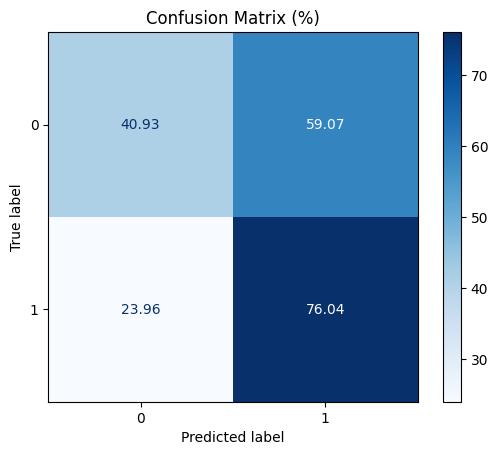

In [42]:
# Cria a matriz de confusão e obtém a figura
fig_confusion_matrix = create_confusion_matrix(model, X_test, y_test)

Plota os resultados durante a fase de treinamento e durante a fase de teste.

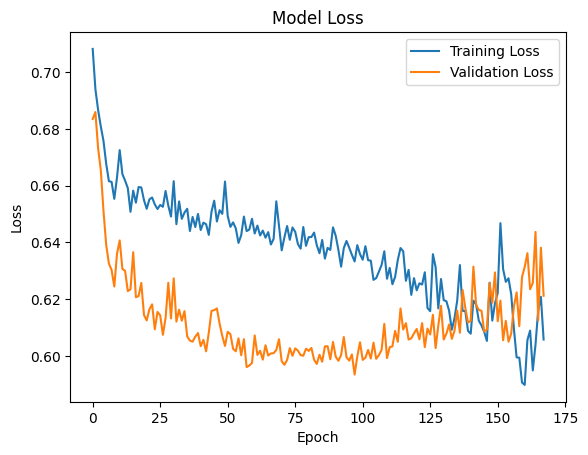

In [43]:
fig_loss = plot_loss(history)

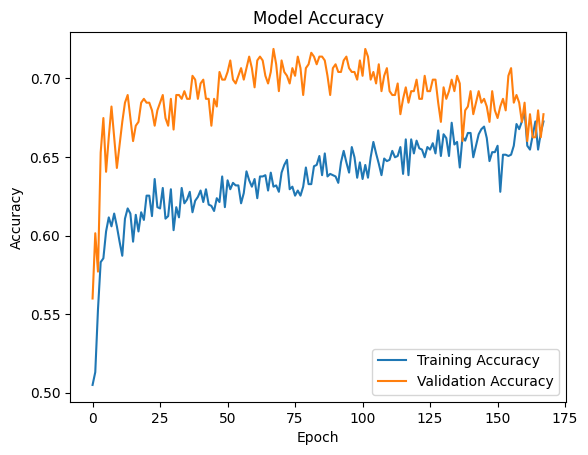

In [44]:
fig_accuracy = plot_accuracy(history)

# **Save Model Metrics & Images**

In [45]:
# Cria o nome do arquivo utilizando a função create_file_name (supondo que ela já esteja definida)
file_name_True = create_file_name(data_source, symbol, max_period, start_date, end_date,
                     timeframe, fisrt_marker, second_marker, third_marker,
                     n_rows, sort, relative_first_marker, relative_second_marker,
                     relative_third_marker, decimals, scaler_type, cols_to_scale,
                     LSTM_boolean, epochs, early_stopping, call_back, patience,
                     batch_size, test_loss, test_accuracy, True)

Salvar o historico do modelo, a loss de teste e a acurácia de teste

In [46]:
# Verifique se o diretório existe, caso contrário, crie-o
verify_directory(caminho_para_salvar_resultados)

caminho_completo_resultados = os.path.join(caminho_para_salvar_resultados, file_name_True + ".json")

# Cria um dicionário com os resultados do modelo
model_results = {
    "history": history.history,  # history.history é um dicionário com os valores das métricas por época
    "test_loss": test_loss,
    "test_accuracy": test_accuracy
}

# Salva os resultados em um arquivo JSON com formatação legível
with open(caminho_completo_resultados, "w") as f:
    json.dump(model_results, f, indent=4)

print("\nFicheiro dos resultados do modelo:")
print(file_name_True + ".json")
print()
print("Ficheiro salvo em:")
print(caminho_para_salvar_resultados)

O diretório /content/drive/MyDrive/AI Financial Analisys/Summer Project/Vasco/Alpaca/Models já existe.

Ficheiro dos resultados do modelo:
ds=iex+s=VOO+mp=False+sd=2016-01-1+ed=2024-12-30+tf=5Min+fm=vwap+sm=trade_count+tm=+r=36+sort=False+rfm=False+rsm=False+rtm=False+d=+st=none+cts=[0]+Lb=True+e=500+es=True+cb=val_accuracy+p=100+bs=128+tl=0.68034428358078+ta=0.5951219797134399.json

Ficheiro salvo em:
/content/drive/MyDrive/AI Financial Analisys/Summer Project/Vasco/Alpaca/Models


Salvar a matriz de confusão, a curva de loss e a curva de precisão

In [47]:
# Verifique se o diretório existe, caso contrário, crie-o~
verify_directory(caminho_para_salvar_imagens)

# Monta o caminho completo para cada imagem
caminho_completo_confusion = os.path.join(caminho_para_salvar_imagens, "cm_" + file_name_True + ".png")
caminho_completo_loss = os.path.join(caminho_para_salvar_imagens, "l_" + file_name_True +  ".png")
caminho_completo_accuracy = os.path.join(caminho_para_salvar_imagens, "a_" + file_name_True + ".png")

# Salva as figuras com alta qualidade (300 dpi)
fig_confusion_matrix.savefig(caminho_completo_confusion, dpi=300, bbox_inches='tight')
fig_loss.savefig(caminho_completo_loss, dpi=300, bbox_inches='tight')
fig_accuracy.savefig(caminho_completo_accuracy, dpi=300, bbox_inches='tight')

print("\nImagens:")
print("Matriz de Confusão:", "confusion_matrix_" + file_name_True + ".png")
print("Gráfico de Loss:", "loss_" + file_name_True + ".png")
print("Gráfico de Accuracy:", "accuracy_" + file_name_True + ".png")
print()
print("Imagens salvas em:")
print(caminho_para_salvar_imagens)

O diretório /content/drive/MyDrive/AI Financial Analisys/Summer Project/Vasco/Images/IEX/NoScaler já existe.

Imagens:
Matriz de Confusão: confusion_matrix_ds=iex+s=VOO+mp=False+sd=2016-01-1+ed=2024-12-30+tf=5Min+fm=vwap+sm=trade_count+tm=+r=36+sort=False+rfm=False+rsm=False+rtm=False+d=+st=none+cts=[0]+Lb=True+e=500+es=True+cb=val_accuracy+p=100+bs=128+tl=0.68034428358078+ta=0.5951219797134399.png
Gráfico de Loss: loss_ds=iex+s=VOO+mp=False+sd=2016-01-1+ed=2024-12-30+tf=5Min+fm=vwap+sm=trade_count+tm=+r=36+sort=False+rfm=False+rsm=False+rtm=False+d=+st=none+cts=[0]+Lb=True+e=500+es=True+cb=val_accuracy+p=100+bs=128+tl=0.68034428358078+ta=0.5951219797134399.png
Gráfico de Accuracy: accuracy_ds=iex+s=VOO+mp=False+sd=2016-01-1+ed=2024-12-30+tf=5Min+fm=vwap+sm=trade_count+tm=+r=36+sort=False+rfm=False+rsm=False+rtm=False+d=+st=none+cts=[0]+Lb=True+e=500+es=True+cb=val_accuracy+p=100+bs=128+tl=0.68034428358078+ta=0.5951219797134399.png

Imagens salvas em:
/content/drive/MyDrive/AI Financia

# **Save Model, Dataset, Scaler & Settings**

Caso o modelo seja corrido em settings originais ou caso o modelo apresente resultados inovadores o modelo será gravado usando esta função e os settings que influenciram o modelo e os resultados obtidos pelo modelo são encriptados no nome do ficheiro no qual o modelo fica guardado.

In [48]:
# Verifique se o diretório existe, caso contrário, crie-o~
verify_directory(caminho_para_salvar_modelo)

caminho_completo_modelo = os.path.join(caminho_para_salvar_modelo, file_name_True + ".keras")

# Salva o modelo em formato
model.save(caminho_completo_modelo)

print("\nFicheiro do Modelo:")
print(file_name_True)
print()
print("Modelo salvo em:")
print(caminho_para_salvar_modelo)

O diretório /content/drive/MyDrive/AI Financial Analisys/Summer Project/Vasco/Alpaca/Models/IEX/NoScaler já existe.

Ficheiro do Modelo:
ds=iex+s=VOO+mp=False+sd=2016-01-1+ed=2024-12-30+tf=5Min+fm=vwap+sm=trade_count+tm=+r=36+sort=False+rfm=False+rsm=False+rtm=False+d=+st=none+cts=[0]+Lb=True+e=500+es=True+cb=val_accuracy+p=100+bs=128+tl=0.68034428358078+ta=0.5951219797134399

Modelo salvo em:
/content/drive/MyDrive/AI Financial Analisys/Summer Project/Vasco/Alpaca/Models/IEX/NoScaler


Caso os dados sejam coletados por uma versão do algoritmo que correu em settings originais os dados seram gravados usando esta função e os settings que influenciram o levaram a obeter os respetivos dados/dataset modelo são encriptados no nome do ficheiro CSV no qual os dados ficam guardados.

In [49]:
# Verifique se o diretório existe, caso contrário, crie-o
verify_directory(caminho_para_salvar_dados)

# Defina o caminho completo para salvar o arquivo
caminho_completo_dados = os.path.join(caminho_para_salvar_dados, file_name_False + ".csv")

# Salve o dataframe no caminho especificado
company_data.to_csv(caminho_completo_dados)

print("\nFicheiro dos Dados:")
print(file_name_False)
print()
print("Dados salvos em:")
print(caminho_para_salvar_dados)

O diretório /content/drive/MyDrive/AI Financial Analisys/Summer Project/Vasco/Data/IEX já existe.

Ficheiro dos Dados:
ds=iex+s=VOO+mp=False+sd=2016-01-1+ed=2024-12-30+tf=5Min

Dados salvos em:
/content/drive/MyDrive/AI Financial Analisys/Summer Project/Vasco/Data/IEX


In [50]:
# Verifique se o diretório existe, caso contrário, crie-o
verify_directory(caminho_para_salvar_dados)

nome_do_ficheiro_scaler = str(scaler_type) + "_" + file_name_False + ".pkl"

# Defina o caminho completo para salvar o arquivo
caminho_completo_scaler = os.path.join(caminho_para_salvar_scaler, nome_do_ficheiro_scaler)

# Salva o scaler na pasta MyDrive (você pode ajustar o caminho conforme necessário)
joblib.dump(scaler, caminho_completo_scaler)

print("\nFicheiro do Scaler:")
print(nome_do_ficheiro_scaler)
print()
print("Dados salvos em:")
print(caminho_para_salvar_dados)

O diretório /content/drive/MyDrive/AI Financial Analisys/Summer Project/Vasco/Data/IEX já existe.

Ficheiro do Scaler:
None_ds=iex+s=VOO+mp=False+sd=2016-01-1+ed=2024-12-30+tf=5Min.pkl

Dados salvos em:
/content/drive/MyDrive/AI Financial Analisys/Summer Project/Vasco/Data/IEX


In [51]:
# Verifique se o diretório existe, caso contrário, crie-o
verify_directory(caminho_para_salvar_settings)

nome_do_ficheiro_settings = "s_" + file_name_True + ".json"

# Defina o caminho completo para salvar o arquivo
caminho_completo_settings = os.path.join(caminho_para_salvar_settings, nome_do_ficheiro_settings)

# Salva as configurações em um arquivo JSON
with open(caminho_completo_settings, 'w') as f:
    json.dump(config, f, indent=4)

print("\nFicheiro dos Settings:")
print(nome_do_ficheiro_settings)
print()
print("Settings salvos em:")
print(caminho_para_salvar_settings)

O diretório /content/drive/MyDrive/AI Financial Analisys/Summer Project/Vasco/Settings já existe.

Ficheiro dos Settings:
s_ds=iex+s=VOO+mp=False+sd=2016-01-1+ed=2024-12-30+tf=5Min+fm=vwap+sm=trade_count+tm=+r=36+sort=False+rfm=False+rsm=False+rtm=False+d=+st=none+cts=[0]+Lb=True+e=500+es=True+cb=val_accuracy+p=100+bs=128+tl=0.68034428358078+ta=0.5951219797134399.json

Settings salvos em:
/content/drive/MyDrive/AI Financial Analisys/Summer Project/Vasco/Settings


# **Model Report**

In [52]:
# Verifique se o diretório existe, caso contrário, crie-o~
verify_directory(caminho_para_salvar_report)

O diretório /content/drive/MyDrive/AI Financial Analisys/Summer Project/Vasco/Report já existe.


In [53]:
# --- Carrega os resultados do modelo (JSON) ---
model_results = {}
if os.path.exists(caminho_completo_resultados):
    try:
        with open(caminho_completo_resultados, 'r', encoding='utf-8') as f:
            model_results = json.load(f)
    except json.JSONDecodeError as e:
        print(f"Erro ao decodificar o JSON de resultados: {e}")
else:
    print("Arquivo de resultados do modelo não encontrado:", caminho_completo_resultados)

test_loss     = model_results.get("test_loss", "N/A")
test_accuracy = model_results.get("test_accuracy", "N/A")
history       = model_results.get("history", {})

# --- Carrega os settings do modelo (JSON) ---
settings = {}
if os.path.exists(caminho_completo_settings):
    try:
        with open(caminho_completo_settings, 'r', encoding='utf-8') as f:
            settings = json.load(f)
    except json.JSONDecodeError as e:
        print(f"Erro ao decodificar o JSON dos settings: {e}")
else:
    print("Arquivo de settings não encontrado:", caminho_completo_settings)

In [54]:
import base64

def image_to_base64(path):
    with open(path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

# Converte as imagens para Base64
confusion_matrix_b64 = image_to_base64(caminho_completo_confusion)
loss_b64 = image_to_base64(caminho_completo_loss)
accuracy_b64 = image_to_base64(caminho_completo_accuracy)

In [55]:
html_content = f"""
<!DOCTYPE html>
<html lang="pt">
<head>
  <meta charset="UTF-8">
  <title>Relatório Interativo do Modelo</title>
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <!-- Google Fonts -->
  <link href="https://fonts.googleapis.com/css2?family=Roboto:wght@400;500;700&display=swap" rel="stylesheet">
  <style>
    :root {{
      --primary-color: #007BFF;
      --secondary-color: #333;
      --accent-color: #FF5722;
      --light-gray: #eaeaea;
      --background-color: #f2f2f2;
    }}

    * {{
      box-sizing: border-box;
      margin: 0;
      padding: 0;
    }}

    body {{
      font-family: 'Roboto', sans-serif;
      background-color: var(--background-color);
      color: var(--secondary-color);
      line-height: 1.6;
      padding-top: 70px;
    }}

    header {{
      position: fixed;
      top: 0;
      left: 0;
      width: 100%;
      background: linear-gradient(135deg, var(--primary-color), var(--accent-color));
      color: #fff;
      padding: 1rem 2rem;
      text-align: center;
      box-shadow: 0 4px 6px rgba(0,0,0,0.1);
      z-index: 1000;
    }}

    header h1 {{
      font-size: 1.8rem;
      letter-spacing: 1px;
    }}

    nav {{
      display: flex;
      justify-content: center;
      background: #fff;
      box-shadow: 0 2px 4px rgba(0,0,0,0.1);
      margin-top: 20px;
      border-radius: 6px;
      overflow: hidden;
    }}

    nav button {{
      flex: 1;
      padding: 1rem;
      border: none;
      background: #fff;
      font-size: 1rem;
      cursor: pointer;
      transition: background 0.3s ease, color 0.3s ease;
    }}

    nav button:hover,
    nav button.active {{
      background: var(--primary-color);
      color: #fff;
    }}

    .container {{
      max-width: 1100px;
      margin: 2rem auto;
      padding: 2rem;
      background: #fff;
      border-radius: 8px;
      box-shadow: 0 4px 12px rgba(0,0,0,0.1);
    }}

    .tab-content {{
      display: none;
      opacity: 0;
      transform: translateX(20px);
      animation: fadeSlide 0.5s forwards;
    }}

    .tab-content.active {{
      display: block;
    }}

    .tab-content img {{
      max-width: 100%;
      border-radius: 8px;
      margin-bottom: 1rem;
      transition: transform 0.3s ease;
    }}

    .tab-content img:hover {{
      transform: scale(1.02);
    }}

    pre {{
      background: var(--light-gray);
      padding: 1rem;
      border-radius: 8px;
      overflow-x: auto;
      font-size: 0.9rem;
    }}

    footer {{
      text-align: center;
      padding: 1rem;
      background: var(--secondary-color);
      color: #fff;
      margin-top: 2rem;
      border-radius: 8px;
    }}

    @keyframes fadeSlide {{
      from {{
        opacity: 0;
        transform: translateX(20px);
      }}
      to {{
        opacity: 1;
        transform: translateX(0);
      }}
    }}

    /* Responsividade */
    @media (max-width: 768px) {{
      header h1 {{
        font-size: 1.5rem;
      }}
      nav button {{
        font-size: 0.9rem;
        padding: 0.8rem;
      }}
      .container {{
        padding: 1.5rem;
        margin: 1rem;
      }}
    }}
  </style>
</head>
<body>
  <header>
    <h1>Relatório Interativo do Modelo</h1>
  </header>

  <nav>
    <button class="tab-link active" data-tab="metrics">Métricas</button>
    <button class="tab-link" data-tab="confusion">Matriz de Confusão</button>
    <button class="tab-link" data-tab="loss">Gráfico de Loss</button>
    <button class="tab-link" data-tab="accuracy">Gráfico de Accuracy</button>
    <button class="tab-link" data-tab="history">Histórico</button>
    <button class="tab-link" data-tab="scaler">Scaler</button>
    <button class="tab-link" data-tab="settings">Settings</button>
  </nav>

  <div class="container">
    <!-- Abas -->
    <div id="metrics" class="tab-content active">
      <h2>Métricas do Teste</h2>
      <p><strong>Test Loss:</strong> <span id="test-loss">{test_loss}</span></p>
      <p><strong>Test Accuracy:</strong> <span id="test-accuracy">{test_accuracy}</span></p>
    </div>

    <div id="confusion" class="tab-content">
      <h2>Matriz de Confusão</h2>
      <img id="confusion-img" src="data:image/png;base64,{confusion_matrix_b64}" alt="Matriz de Confusão">
    </div>

    <div id="loss" class="tab-content">
      <h2>Gráfico de Loss</h2>
      <img id="loss-img" src="data:image/png;base64,{loss_b64}" alt="Gráfico de Loss">
    </div>

    <div id="accuracy" class="tab-content">
      <h2>Gráfico de Accuracy</h2>
      <img id="accuracy-img" src="data:image/png;base64,{accuracy_b64}" alt="Gráfico de Accuracy">
    </div>

    <div id="history" class="tab-content">
      <h2>Histórico de Treinamento</h2>
      <pre id="history-json">{json.dumps(history, indent=2, ensure_ascii=False)}</pre>
    </div>

    <div id="scaler" class="tab-content">
      <h2>Scaler</h2>
      <p>Arquivo do Scaler: <strong>{nome_do_ficheiro_scaler}</strong></p>
      <p><a href="file://{caminho_completo_scaler}" download>Baixar Scaler</a></p>
    </div>

    <div id="settings" class="tab-content">
      <h2>Settings</h2>
      <p>Arquivo de Settings: <strong>{nome_do_ficheiro_settings}</strong></p>
      <p><a href="file://{caminho_completo_settings}" download>Baixar Settings</a></p>
      <pre id="settings-json">{json.dumps(settings, indent=2, ensure_ascii=False)}</pre>
    </div>
  </div>

  <footer>
    <p>&copy; 2025 Prometheus</p>
  </footer>

  <script>
    // Troca de abas com animação
    document.querySelectorAll('.tab-link').forEach(button => {{
      button.addEventListener('click', () => {{
        document.querySelectorAll('.tab-link').forEach(btn => btn.classList.remove('active'));
        document.querySelectorAll('.tab-content').forEach(content => {{
          content.classList.remove('active');
          // Força reinício da animação removendo a classe e re-adicionando após um pequeno delay
          content.style.animation = 'none';
          setTimeout(() => {{
            content.style.animation = '';
          }}, 10);
        }});
        button.classList.add('active');
        const tab = button.getAttribute('data-tab');
        document.getElementById(tab).classList.add('active');
      }});
    }});

    // Injeção dos dados do modelo (os dados já estão incorporados no HTML)
    const modelResults = {json.dumps(model_results, indent=2, ensure_ascii=False)};
    document.getElementById('test-loss').textContent = modelResults.test_loss;
    document.getElementById('test-accuracy').textContent = modelResults.test_accuracy;
    document.getElementById('history-json').textContent = JSON.stringify(modelResults.history, null, 2);
    document.getElementById('settings-json').textContent = JSON.stringify({json.dumps(settings, indent=2, ensure_ascii=False)}, null, 2);
  </script>
</body>
</html>
"""

In [56]:
# --- Grava o relatório HTML ---
report_file_path = os.path.join(caminho_para_salvar_report, file_name_True + ".html")
with open(report_file_path, "w", encoding="utf-8") as f:
    f.write(html_content)

print("\nFicheiro do Report:")
print(file_name_True + ".html")
print()
print("Report salvo em:")
print(caminho_para_salvar_report)


Ficheiro do Report:
ds=iex+s=VOO+mp=False+sd=2016-01-1+ed=2024-12-30+tf=5Min+fm=vwap+sm=trade_count+tm=+r=36+sort=False+rfm=False+rsm=False+rtm=False+d=+st=none+cts=[0]+Lb=True+e=500+es=True+cb=val_accuracy+p=100+bs=128+tl=0.68034428358078+ta=0.5951219797134399.html

Report salvo em:
/content/drive/MyDrive/AI Financial Analisys/Summer Project/Vasco/Report
